In [1]:
import numpy as np, xarray as xr, pandas as pd, pandas as pd, math, time, os # For data handling
import cartopy.crs as ccrs, matplotlib.pyplot as plt, matplotlib as mpl  # For plotting
from utils import *                                                      # Helper functions
import dask.array as da                                                  # For faster computations
from dask.diagnostics import ProgressBar                                 # For computation feedback
#from dask.distributed import Client, LocalCluster                        # For parallelization
from datetime import datetime                                            # For calender handling
import s3fs                                                              # For reading bucket data
from ipywidgets import interact, interactive, fixed, widgets             # For interactive plotting
import statsmodels.formula.api as sm                                     # For regression
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["text.usetex"] = True                                       # For compiling tex
%load_ext autoreload
%autoreload 2                                                            # To auto-reload modules
%reload_ext autoreload

s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD",                       # Key to bucket
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

### Parallel cluster setup

In [13]:
client.close()

In [2]:
cluster = LocalCluster(n_workers=8, memory_limit='32GB') #16 is best (matches number of cores)
client = Client(cluster)

# Temperature

In [ ]:
tosBS = clip_to_region(get_bucket_data('tos', thing='Omon', model='NorESM2-LM', experiment='historical'))

In [ ]:
tos_anomaly = time_anomaly(tosBS, 0, 12*30, -12*30, -1)
tos_anomaly.plot()

In [ ]:
tosBSmean = regional_average(tosBS.tos.isel(time=slice(-12*70, -1)), model='NorESM2-LM')
tosBSmean.isel(time=slice(-12*50, -1)).plot(x='time')

# Sea Ice

In [ ]:
SI = clip_to_region(get_bucket_data('siconc', thing='SImon', model='NorESM2-LM', experiment='historical'))

In [ ]:
SImean = regional_average(SI, model='NorESM-LM')

SIMarch = SI.groupby('time.month')[3]
SIMarchSpatialMean = regional_average(SIMarch, areacello.areacello)

SISeptember = SI.groupby('time.month')[9]
SISeptemberSpatialMean = regional_average(SISeptember, areacello.areacello)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,8))

SIMarchSpatialMean.isel(time=slice(-12*65, -1)).plot(ax=ax[0,0])
SISeptemberSpatialMean.isel(time=slice(-12*65, -1)).plot(ax=ax[0,1])

time_anomaly(SIMarch, 0, 12*30, -12*30, -1).plot(ax=ax[1,0])
time_anomaly(SISeptember, 0, 12*30, -12*30, -1).plot(ax=ax[1,1])

plt.show()

In [ ]:
SImeanMarch = SImean.groupby('time.month')[3]
SImeanSeptember = SImean.groupby('time.month')[9]
SImeanMarch.plot()
SImeanSeptember.plot()

# Chlorophyll

## Observations

In [2]:
chlos_mon_sat = clip_to_region(xr.load_dataset('OBS-ESACCI-OC.nc')) # Monthly satellite observation of Chlorophyll

In [13]:
slider_map(chlos_mon_sat.chl, datetime(1997, 10, 1), datetime(2017, 10, 1))

interactive(children=(SelectionSlider(description='date', layout=Layout(width='800px'), options=(('1997-10', T…

## Get data

In [2]:
path_to_folder = '/nird/projects/NS9252K/ada_escience/CLIPPED_files/'

In [3]:
#os.listdir(path_to_folder)

In [4]:
chlosCesmHist = consistent_naming(xr.open_dataset(path_to_folder + 'chlos_clipped_Oday_CESM2_historical_r1i1p1f1_gn_18500102-20150101.nc'))
chlosCesmHist = to_datetime_index(clip_to_region(chlosCesmHist.chlos, minlat=75, minlon=20, maxlon=60, maxlat=80).isel(time=slice(0, -1)))

In [5]:
chlosNoresmHist = consistent_naming(xr.open_dataset(path_to_folder + 'chlos_clipped_Oday_NorESM2-LM_historical_r1i1p1f1_gn_18500102-20150101.nc'))
chlosNoresmHist = to_datetime_index(clip_to_region(chlosNoresmHist.chlos, minlat=75, maxlat=80, minlon=20, maxlon=60))

In [6]:
SICesmHist = consistent_naming(xr.open_dataset(path_to_folder + 'siconc_clipped_SIday_CESM2_historical_r1i1p1f1_gn_18500102-20150101.nc'))
SICesmHist = to_datetime_index(clip_to_region(SICesmHist.siconc, minlat=75, minlon=20, maxlon=60, maxlat=80).isel(time=slice(0,-1)))
SINoresmHist = consistent_naming(xr.open_dataset(path_to_folder + 'siconc_clipped_SIday_NorESM2-LM_historical_r1i1p1f1_gn_18500102-20150101.nc'))
SINoresmHist = to_datetime_index(clip_to_region(SINoresmHist.siconc, minlat=75, minlon=20, maxlon=60, maxlat=80))

In [7]:
TOSCesmHist = consistent_naming(xr.open_dataset(path_to_folder + 'tos_clipped_Oday_CESM2_historical_r1i1p1f1_gn_18500102-20150101.nc'))
TOSCesmHist = to_datetime_index(clip_to_region(TOSCesmHist.tos, minlat=75, minlon=20, maxlon=60, maxlat=80).isel(time=slice(0,-1)))
TOSNoresmHist = consistent_naming(xr.open_dataset(path_to_folder + 'tos_clipped_Oday_NorESM2-LM_historical_r1i1p1f1_gn_18500102-20150101.nc'))
TOSNoresmHist = to_datetime_index(clip_to_region(TOSNoresmHist.tos, minlat=75, minlon=20, maxlon=60, maxlat=80))

In [424]:
MLCesmHist = consistent_naming(xr.open_dataset(path_to_folder + 'omldamax_clipped_Oday_CESM2_historical_r1i1p1f1_gn_18500102-20150101.nc'))
MLCesmHist = to_datetime_index(clip_to_region(MLCesmHist.omldamax, minlat=75, minlon=20, maxlon=60, maxlat=80).isel(time=slice(0,-1)))
MLNoresmHist = consistent_naming(xr.open_dataset(path_to_folder + 'omldamax_clipped_Oday_NorESM2-LM_historical_r1i1p1f1_gn_18500102-20150101.nc'))
MLNoresmHist = to_datetime_index(clip_to_region(MLNoresmHist.omldamax, minlat=75, minlon=20, maxlon=60, maxlat=80))

### Calculations

In [37]:
TOSCesmHistDates = find_first_dates(TOSCesmHist, 0, over=True)
TOSNoresmHistDates = find_first_dates(TOSNoresmHist, 0, over=True)

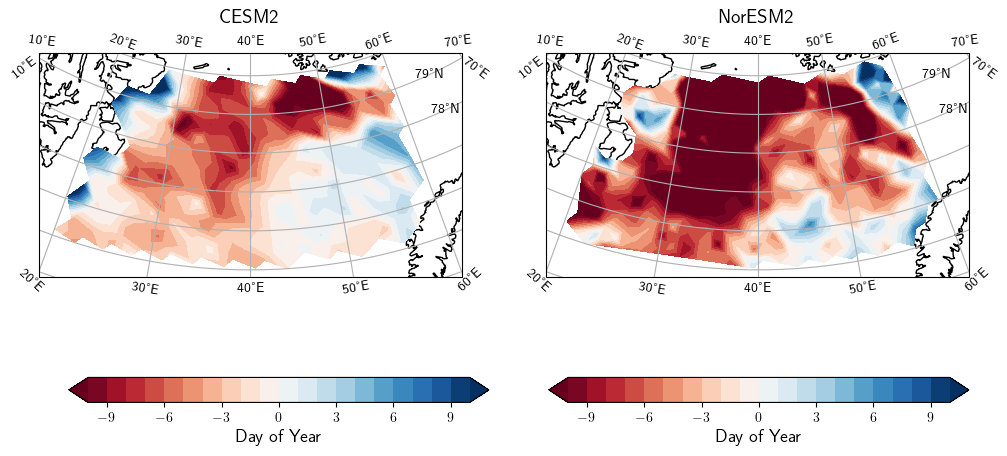

In [51]:
fig, ax = barentsMap(minlat=74, figsize=(12,5), ncols=2)
_xrds = time_anomaly(TOSCesmHistDates, 0, 30, -30, -1)
norm = mpl.colors.TwoSlopeNorm(vcenter=0)
pCesm = ax[0].contourf(_xrds.lon,
                _xrds.lat,
                _xrds.values,
                transform=ccrs.PlateCarree(),
                levels=np.linspace(-10, 10, 21).round(0),
                extend='both',
                cmap=plt.get_cmap('RdBu'))

cbar_ax = fig.add_axes([0.15, 0.02, 0.35, 0.05])
cbar = fig.colorbar(pCesm, cax=cbar_ax, orientation='horizontal')
cbar.set_label(label='Day of Year',size=13,weight='bold')
ax[0].set_title('CESM2', fontsize=14)

_xrds = time_anomaly(TOSNoresmHistDates, 0, 30, -30, -1)
pNoresm = ax[1].contourf(_xrds.lon,
                _xrds.lat,
                _xrds.values,
                transform=ccrs.PlateCarree(),
                levels=np.linspace(-10, 10, 21).round(0),
                extend='both',
                cmap=plt.get_cmap('RdBu'))

cbar_ax = fig.add_axes([0.55, 0.02, 0.35, 0.05])
cbar = fig.colorbar(pNoresm, cax=cbar_ax, orientation='horizontal')
cbar.set_label(label='Day of Year',size=13,weight='bold')
ax[1].set_title('NorESM2', fontsize=14)

plt.show()

In [460]:
TOSCesmHistDatesMean = regional_average(TOSCesmHistDates, model='CESM2')
TOSNoresmHistDatesMean = regional_average(TOSNoresmHistDates, model='NorESM2-LM')

Found local areacello NetCDF
Found local areacello NetCDF


#### Amount anomalies

In [10]:
chlosCesmAnomaly = time_anomaly(chlosCesmHist.chlos, 0, 365*30, -365*30, -1, relative=True)
chlosNoresmAnomaly = time_anomaly(chlosNoresmHist.chlos, 0, 365*30, -365*30, -1, relative=True)

In [11]:
SICesmHistAnomaly = time_anomaly(SICesmHist.siconc, 0, 365*30, -365*30, -1, relative=True)
SINoresmHistAnomaly = time_anomaly(SINoresmHist.siconc, 0, 365*30, -365*30, -1, relative=True)

In [12]:
TOSCesmHistAnomaly = time_anomaly(TOSCesmHist.tos, 0, 365*30, -365*30, -1, relative=False)
TOSNoresmHistAnomaly = time_anomaly(TOSNoresmHist.tos, 0, 365*30, -365*30, -1, relative=False)

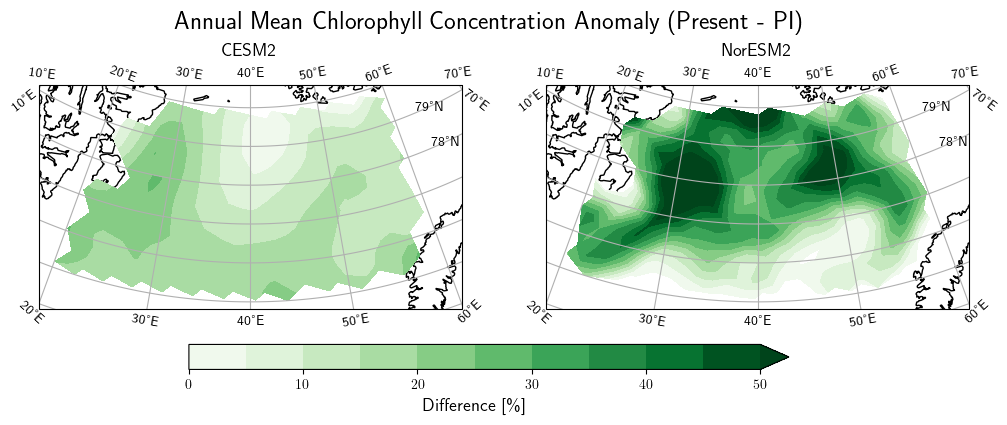

In [14]:
anomaly_plot(chlosCesmAnomaly, chlosNoresmAnomaly, 'Annual Mean Chlorophyll Concentration Anomaly (Present - PI)', 
             extend='max', levels=np.linspace(0, 50, 11), savefig='chlos_amount_anomaly.png')

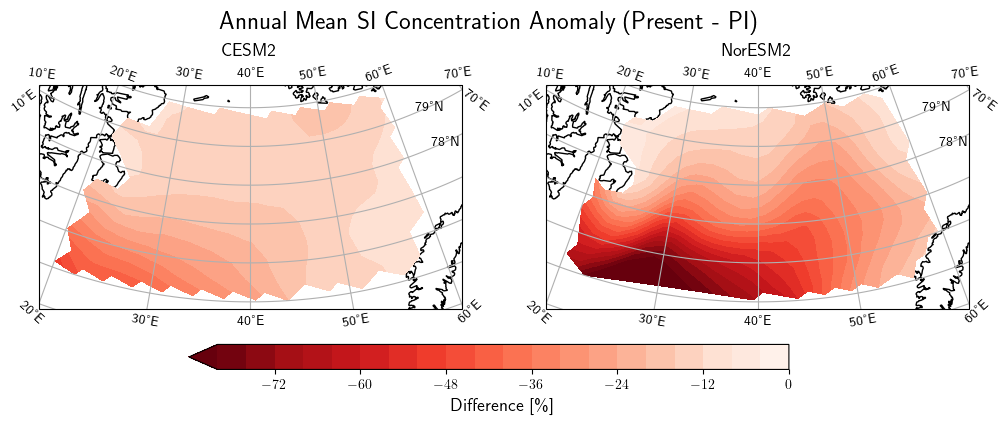

In [15]:
anomaly_plot(SICesmHistAnomaly, SINoresmHistAnomaly, 'Annual Mean SI Concentration Anomaly (Present - PI)', 
             cmap='Reds_r', levels=np.linspace(-80, 0, 21), extend='min' , savefig='SI_amount_anomaly.png')

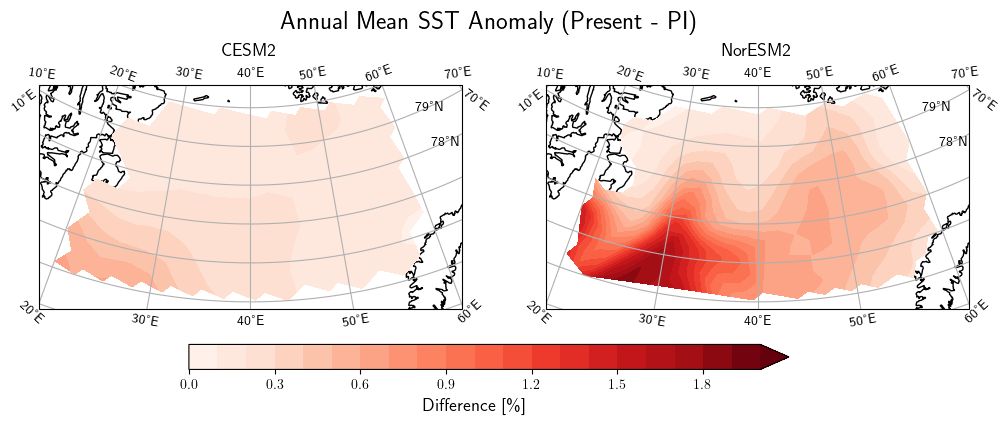

In [16]:
anomaly_plot(TOSCesmHistAnomaly, TOSNoresmHistAnomaly, 'Annual Mean SST Anomaly (Present - PI)', 
             cmap='Reds', levels=np.linspace(0, 2, 21), extend='max', savefig='TOS_anomaly.png')

### Finding dates

In [9]:
chlosCesmHistPeaks = find_peak_dates(chlosCesmHist)
chlosNoresmHistPeaks = find_peak_dates(chlosNoresmHist)

In [61]:
SICesmHistDates = find_first_dates(SICesmHist, 50, over=False)
SINoresmHistDates = find_first_dates(SINoresmHist, 50, over=False)

In [409]:
SICesmHistDates15 = find_first_dates(SICesmHist, 15, over=False)
SINoresmHistDates15 = find_first_dates(SINoresmHist, 15, over=False)

In [227]:
TOSCesmHistDates = find_first_dates(TOSCesmHist, -0.5, over=True, time_cutoff=200)
TOSNoresmHistDates = find_first_dates(TOSNoresmHist, -0.5, over=True, time_cutoff=200)

#### Peak anomalies

In [67]:
chlosCesmHistPeaksAnomaly = time_anomaly(chlosCesmHistPeaks, 0, 100, -30, -1)
chlosNoresmHistPeaksAnomaly = time_anomaly(chlosNoresmHistPeaks, 0, 100, -30, -1)

In [68]:
SICesmHistDatesAnomaly = time_anomaly(SICesmHistDates, 0, 100, -30, -1)
SINoresmHistDatesAnomaly = time_anomaly(SINoresmHistDates, 0, 100, -30, -1)

In [249]:
TOSCesmHistDatesAnomaly = time_anomaly(TOSCesmHistDates, 0, 100, -30, -1)
TOSNoresmHistDatesAnomaly = time_anomaly(TOSNoresmHistDates, 0, 100, -30, -1)

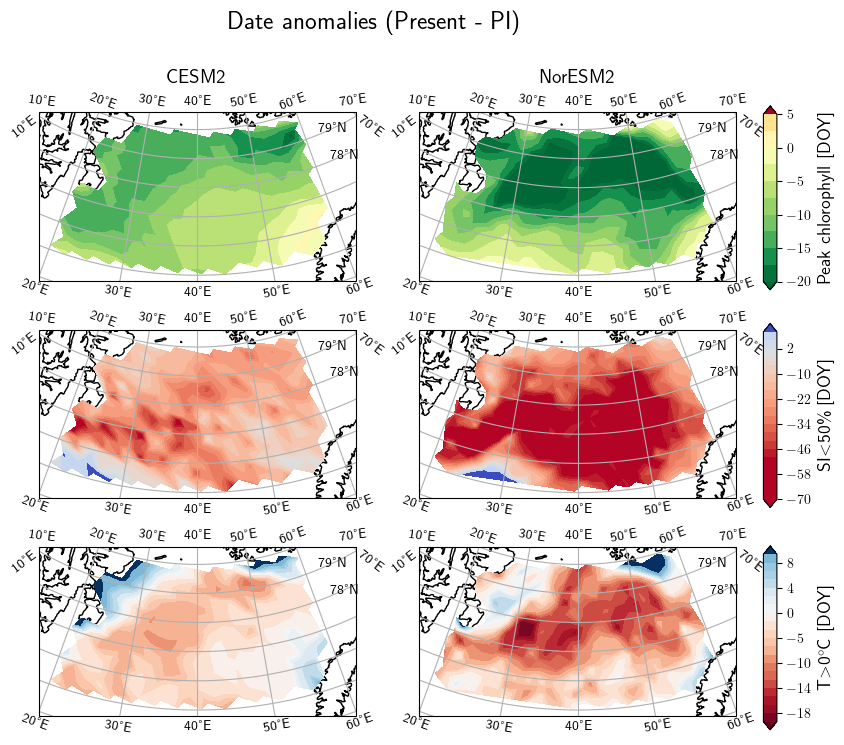

In [242]:
fig, axs = barentsMap(minlat=74, ncols=2, nrows=3, figsize=(9,8))

# Chlorophyll on row 1
cLevels = np.linspace(-20, 5, 11).round(0)
cNorm = mpl.colors.CenteredNorm(vcenter=0)
cCesm = axs[0, 0].contourf(chlosCesmHistPeaksAnomaly.longitude,
                chlosCesmHistPeaksAnomaly.latitude,
                chlosCesmHistPeaksAnomaly.values,
                transform=ccrs.PlateCarree(),
                levels=cLevels,
                extend='both',
                cmap=plt.get_cmap('RdYlGn_r'),
                norm=cNorm)
cNoresm = axs[0, 1].contourf(chlosNoresmHistPeaksAnomaly.longitude,
                chlosNoresmHistPeaksAnomaly.latitude,
                chlosNoresmHistPeaksAnomaly.values,
                transform=ccrs.PlateCarree(),
                levels=cLevels,
                extend='both',
                cmap=plt.get_cmap('RdYlGn_r'),
                norm=cNorm)

c_ax = fig.add_axes([0.93, 0.65, 0.015, 0.23])
c_cbar = fig.colorbar(cCesm, cax=c_ax, orientation='vertical')
c_cbar.set_label(label='Peak chlorophyll [DOY]',size=13,weight='bold')
axs[0, 0].set_title('CESM2', fontsize=14)
axs[0, 1].set_title('NorESM2', fontsize=14)



# Sea Ice breakup dates row 2
iNorm = mpl.colors.CenteredNorm(vcenter=0, halfrange=50)
iLevels = np.linspace(-70, 10, 21).round(0)
iCesm = axs[1, 0].contourf(SICesmHistDatesAnomaly.lon,
                SICesmHistDatesAnomaly.lat,
                SICesmHistDatesAnomaly.values,
                transform=ccrs.PlateCarree(),
                levels=iLevels,
                extend='both',
                cmap=plt.get_cmap('coolwarm_r'),
                norm=iNorm)
iNoresm = axs[1, 1].contourf(SINoresmHistDatesAnomaly.lon,
                SINoresmHistDatesAnomaly.lat,
                SINoresmHistDatesAnomaly.values,
                transform=ccrs.PlateCarree(),
                levels=iLevels,
                extend='both',
                cmap=plt.get_cmap('coolwarm_r'),
                norm=iNorm)

i_ax = fig.add_axes([0.93, 0.378, 0.015, 0.23])
i_cbar = fig.colorbar(iCesm, cax=i_ax, orientation='vertical')
i_cbar.set_label(label='SI$<$50\% [DOY]',size=13,weight='bold')


# Temperature over 0 dates on 3. row
tNorm = mpl.colors.CenteredNorm(vcenter=0, halfrange=20)
tLevels = np.linspace(-20, 10, 21).round(0)
tCesm = axs[2, 0].contourf(TOSCesmHistDatesAnomaly.longitude,
                TOSCesmHistDatesAnomaly.latitude,
                TOSCesmHistDatesAnomaly.values,
                transform=ccrs.PlateCarree(),
                levels=tLevels,
                extend='both',
                cmap=plt.get_cmap('RdBu'),
                norm=tNorm)
tNoresm = axs[2, 1].contourf(TOSNoresmHistDatesAnomaly.longitude,
                TOSNoresmHistDatesAnomaly.latitude,
                TOSNoresmHistDatesAnomaly.values,
                transform=ccrs.PlateCarree(),
                levels=tLevels,
                extend='both',
                cmap=plt.get_cmap('RdBu'),
                norm=tNorm)

t_ax = fig.add_axes([0.93, 0.1, 0.015, 0.23])
t_cbar = fig.colorbar(tCesm, cax=t_ax, orientation='vertical')
t_cbar.set_label(label='T$>$0$^\circ$C [DOY]',size=13,weight='bold')

fig.suptitle('Date anomalies (Present - PI)', fontsize=18, y=1)
plt.savefig('plots/PBD_Anomaly.png')
plt.show()

#### Peak scatter

In [196]:
chlosCesmHistPeaksMean, chlosCesmHistPeaksStd = regional_average(chlosCesmHistPeaks, model='CESM2', std=True)
chlosNoresmHistPeaksMean, chlosNoresmHistPeaksStd = regional_average(chlosNoresmHistPeaks, model='NorESM2-LM', std=True)

Found local areacello NetCDF
Found local areacello NetCDF


hei
hei


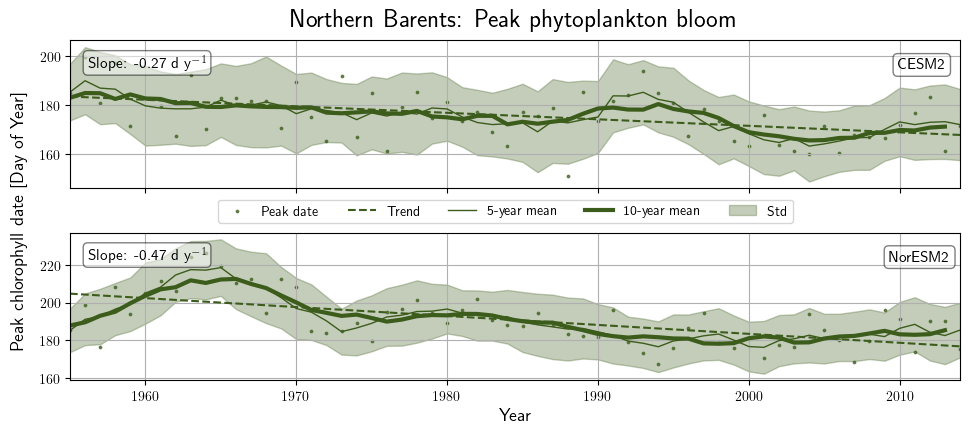

In [198]:
fig, axs = plt.subplots(nrows=2, figsize=(10,4), sharex=True)

reg60cesm = scatter_dates(chlosCesmHistPeaksMean, last_n_years=60, ax=axs[0], reg_results=True, 
                          source='CESM2', color='#3C5C1B', anomaly=False, std=chlosCesmHistPeaksStd)
reg60noresm = scatter_dates(chlosNoresmHistPeaksMean, last_n_years=60, ax=axs[1], reg_results=True, 
                            source='NorESM2', color='#3C5C1B', anomaly=False, std=chlosCesmHistPeaksStd)

scatter_dates_layout(reg60cesm, reg60noresm, fig, axs, figname='scatter_peaks_60')

In [410]:
SICesmHistDatesMean, SICesmHistDatesStd = regional_average(SICesmHistDates, model='CESM2', std=True)
SINoresmHistDatesMean, SINoresmHistDatesStd = regional_average(SINoresmHistDates, model='NorESM2-LM', std=True)

Found local areacello NetCDF
Found local areacello NetCDF
Found local areacello NetCDF
Found local areacello NetCDF


hei
hei


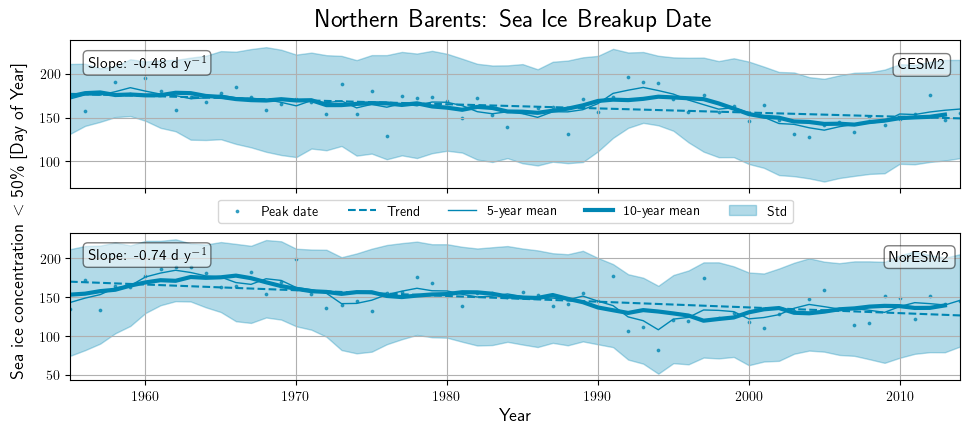

In [199]:
fig, axs = plt.subplots(nrows=2, figsize=(10,4), sharex=True)

SIreg60cesm = scatter_dates(SICesmHistDatesMean, last_n_years=60, ax=axs[0], anomaly=False, 
                            reg_results=True, source='CESM2', color='#0086b3', std=SICesmHistDatesStd)
SIreg60noresm = scatter_dates(SINoresmHistDatesMean, last_n_years=60, ax=axs[1], reg_results=True, 
                              source='NorESM2', color='#0086b3', anomaly=False, std=SINoresmHistDatesStd)

scatter_dates_layout(SIreg60cesm, SIreg60noresm, fig, axs, 
                     title='Northern Barents: Sea Ice Breakup Date', 
                     ylabel='Sea ice concentration $<$ 50\% [Day of Year]', 
                     figname='SI_scatter_peaks_60')

In [247]:
TOSCesmHistDatesMean, TOSCesmHistDatesStd = regional_average(TOSCesmHistDates, model='CESM2', std=True)
TOSNoresmHistDatesMean, TOSNoresmHistDatesStd = regional_average(TOSNoresmHistDates, model='NorESM2-LM', std=True)

Found local areacello NetCDF
Found local areacello NetCDF


hei
hei


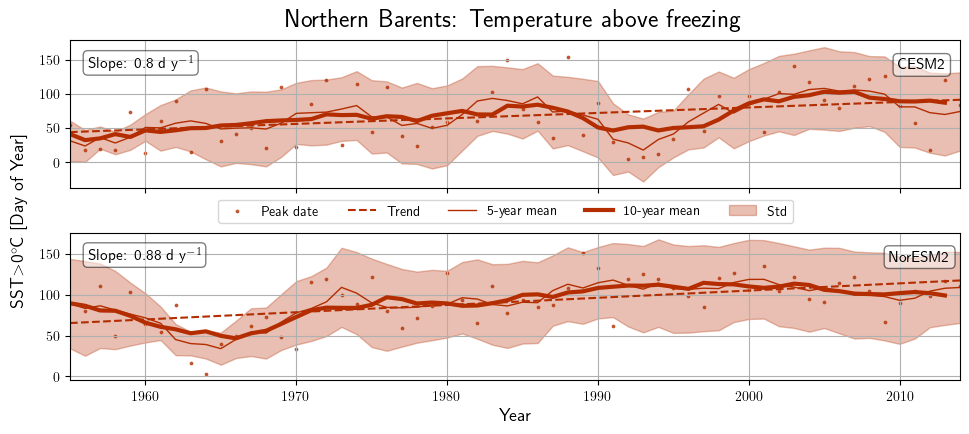

In [248]:
fig, axs = plt.subplots(nrows=2, figsize=(10,4), sharex=True)

TOSreg60cesm = scatter_dates(TOSCesmHistDatesMean, last_n_years=60, ax=axs[0], reg_results=True, 
                             source='CESM2', color='#b32d00', anomaly=False, std=TOSCesmHistDatesStd)
TOSreg60noresm = scatter_dates(TOSNoresmHistDatesMean, last_n_years=60, ax=axs[1], reg_results=True, 
                               source='NorESM2', color='#b32d00', anomaly=False, std=TOSNoresmHistDatesStd)

scatter_dates_layout(TOSreg60cesm, TOSreg60noresm, fig, axs, 
                     title='Northern Barents: Temperature above freezing', 
                     ylabel='SST$>$0$^\circ$C [Day of Year]', 
                     figname='SI_scatter_peaks_60')

### Sliders

In [11]:
slider_map(chlosNoresm.chlos, freq='D', start=datetime(2013, 4, 1), stop=datetime(2014, 10, 1), 
           name='PC NorESM2-LM', model=True, minlat=74)

interactive(children=(SelectionSlider(description='date', layout=Layout(width='800px'), options=(('2013-04-01'…

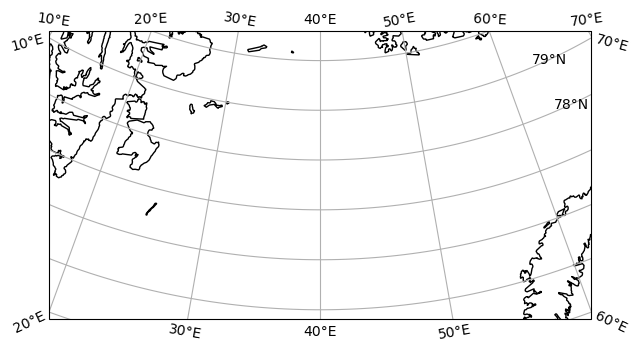

interactive(children=(SelectionSlider(description='date', layout=Layout(width='800px'), options=(('2013-01', T…

In [14]:
slider_map(SINoresm.siconc, freq='M', start=datetime(2013, 1, 1), stop=datetime(2014, 12, 1), minlat=74, 
           name='SIC NorESM2-LM', model=True, color='Blues', levels=np.linspace(0, 100, 21))

### Dependence on Sea Ice Concentration

In [420]:
SICesmHistDates15 = find_first_dates(SICesmHist, 15, over=False)
SINoresmHistDates15 = find_first_dates(SINoresmHist, 15, over=False)

SICesmHistDates80 = find_first_dates(SICesmHist, 80, over=False)
SINoresmHistDates80 = find_first_dates(SINoresmHist, 80, over=False)

SICesmHistDates90 = find_first_dates(SICesmHist, 90, over=False)
SINoresmHistDates90 = find_first_dates(SINoresmHist, 90, over=False)

In [421]:
SICesmHistDates15Mean, SICesmHistDates15Std = regional_average(SICesmHistDates15, model='CESM2', std=True)
SINoresmHistDates15Mean, SINoresmHistDates15Std = regional_average(SINoresmHistDates15, model='NorESM2-LM', std=True)

SICesmHistDates80Mean, SICesmHistDates15Std = regional_average(SICesmHistDates80, model='CESM2', std=True)
SINoresmHistDates80Mean, SINoresmHistDates15Std = regional_average(SINoresmHistDates80, model='NorESM2-LM', std=True)

SICesmHistDates90Mean, SICesmHistDates15Std = regional_average(SICesmHistDates90, model='CESM2', std=True)
SINoresmHistDates90Mean, SINoresmHistDates15Std = regional_average(SINoresmHistDates90, model='NorESM2-LM', std=True)

Found local areacello NetCDF
Found local areacello NetCDF
Found local areacello NetCDF
Found local areacello NetCDF
Found local areacello NetCDF
Found local areacello NetCDF


In [177]:
regCesm = regression(SICesmHistDatesMean, chlosCesmHistPeaksMean)
regNoresm = regression(SINoresmHistDatesMean, chlosNoresmHistPeaksMean)

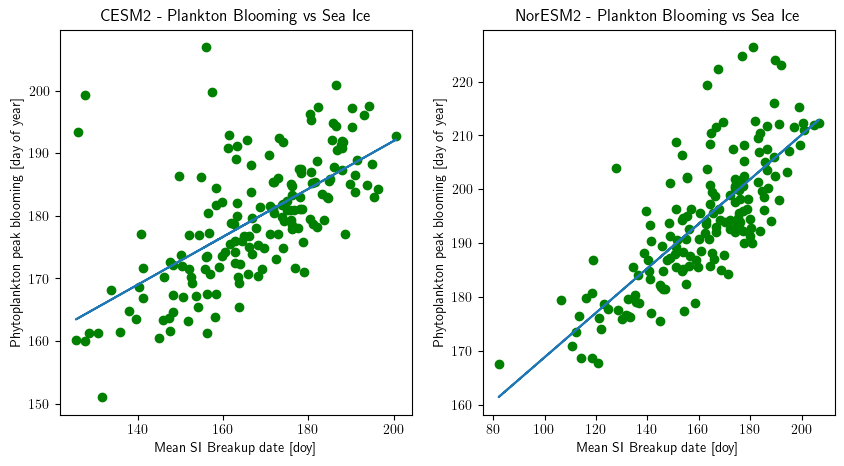

In [176]:
fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
ax[0].set_xlabel('Mean SI Breakup date [doy]')
ax[0].set_ylabel('Phytoplankton peak blooming [day of year]')
ax[0].set_title('CESM2 - Plankton Blooming vs Sea Ice')
ax[0].scatter(SICesmHistDatesMean.values, chlosCesmHistPeaksMean.values, color='g')
ax[0].plot(SICesmHistDatesMean.values, regCesm.params[1] * SICesmHistDatesMean.values + regCesm.params[0])
ax[1].set_xlabel('Mean SI Breakup date [doy]')
ax[1].set_ylabel('Phytoplankton peak blooming [day of year]')
ax[1].set_title('NorESM2 - Plankton Blooming vs Sea Ice')
ax[1].scatter(SINoresmHistDatesMean.values, chlosNoresmHistPeaksMean.values, color='g')
ax[1].plot(SINoresmHistDatesMean.values, regNoresm.params[1] * SINoresmHistDatesMean.values + regNoresm.params[0])

### Dependence on Temperature

In [460]:
def monthly_mean(da, month_number, model, suppress_feedback=True):
    return regional_average(da.resample(time="M").mean().groupby('time.month')[month_number], model=model, suppress_feedback=suppress_feedback)

In [397]:
TOSCesmHistMayMean = regional_average(TOSCesmHist.resample(time="M").mean().groupby('time.month')[5], model='CESM2')
TOSNoresmHistMayMean = regional_average(TOSNoresmHist.resample(time="M").mean().groupby('time.month')[5], model='NorESM2-LM')

TOSCesmHistJuneMean = regional_average(TOSCesmHist.resample(time="M").mean().groupby('time.month')[6], model='CESM2')
TOSNoresmHistJuneMean = regional_average(TOSNoresmHist.resample(time="M").mean().groupby('time.month')[6], model='NorESM2-LM')

TOSCesmHistJulyMean = regional_average(TOSCesmHist.resample(time="M").mean().groupby('time.month')[7], model='CESM2')
TOSNoresmHistJulyMean = regional_average(TOSNoresmHist.resample(time="M").mean().groupby('time.month')[7], model='NorESM2-LM')

TOSCesmHistAugMean = regional_average(TOSCesmHist.resample(time="M").mean().groupby('time.month')[8], model='CESM2')
TOSNoresmHistAugMean = regional_average(TOSNoresmHist.resample(time="M").mean().groupby('time.month')[8], model='NorESM2-LM')

Found local areacello NetCDF
Found local areacello NetCDF
Found local areacello NetCDF
Found local areacello NetCDF
Found local areacello NetCDF
Found local areacello NetCDF
Found local areacello NetCDF
Found local areacello NetCDF


In [465]:
TOSCesmHistMayMean['time'] = np.arange(1850, 2015)
TOSNoresmHistMayMean['time'] = np.arange(1850, 2015)

TOSCesmHistJuneMean['time'] = np.arange(1850, 2015)
TOSNoresmHistJuneMean['time'] = np.arange(1850, 2015)

TOSCesmHistJulyMean['time'] = np.arange(1850, 2015)
TOSNoresmHistJulyMean['time'] = np.arange(1850, 2015)

hei
hei


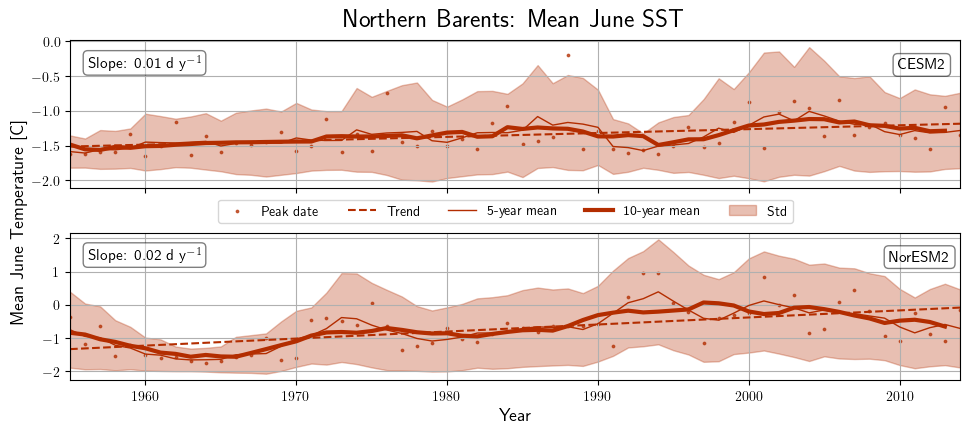

In [466]:
fig, axs = plt.subplots(nrows=2, figsize=(10,4), sharex=True)

TOSreg60cesm = scatter_dates(TOSCesmHistJuneMean, last_n_years=60, ax=axs[0], reg_results=True, 
                             source='CESM2', color='#b32d00', anomaly=False, std=TOSCesmHistJuneStd)
TOSreg60noresm = scatter_dates(TOSNoresmHistJuneMean, last_n_years=60, ax=axs[1], reg_results=True, 
                               source='NorESM2', color='#b32d00', anomaly=False, std=TOSNoresmHistJuneStd)

scatter_dates_layout(TOSreg60cesm, TOSreg60noresm, fig, axs, 
                     title='Northern Barents: Mean June SST', 
                     ylabel='Mean June Temperature [C]', 
                     figname='SI_scatter_peaks_60')

In [ ]:
fig, axs = plt.subplots(nrows=2, figsize=(10,4), sharex=True)

TOSreg60cesm = scatter_dates(TOSCesmHistJuneMean, last_n_years=60, ax=axs[0], reg_results=True, 
                             source='CESM2', color='#b32d00', anomaly=False, std=TOSCesmHistJuneStd)
TOSreg60noresm = scatter_dates(TOSNoresmHistJuneMean, last_n_years=60, ax=axs[1], reg_results=True, 
                               source='NorESM2', color='#b32d00', anomaly=False, std=TOSNoresmHistJuneStd)

scatter_dates_layout(TOSreg60cesm, TOSreg60noresm, fig, axs, 
                     title='Northern Barents: Mean June SST', 
                     ylabel='Mean June Temperature [C]', 
                     figname='SI_scatter_peaks_60')

In [453]:
regCesm = regression(TOSCesmHistJuneMean, chlosCesmHistPeaksMean)
regNoresm = regression(TOSNoresmHistJuneMean, chlosNoresmHistPeaksMean)

(167.5927125226503, 226.43082369381128)

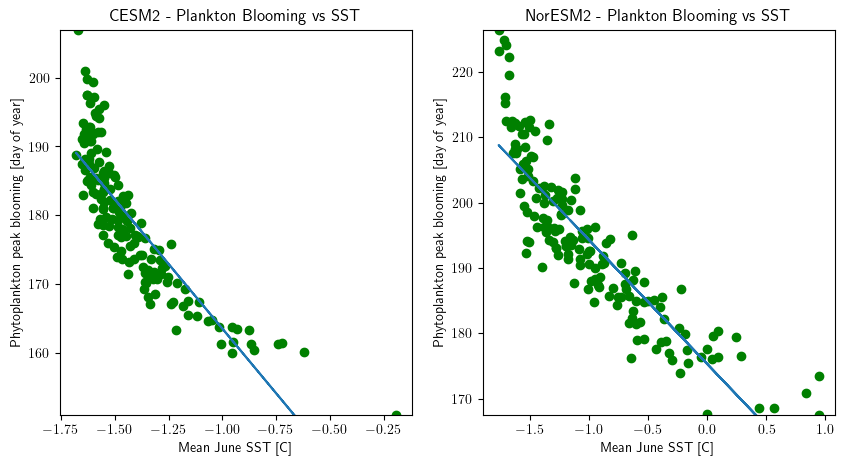

In [366]:
fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
ax[0].set_xlabel('Mean June SST [C]')
ax[0].set_ylabel('Phytoplankton peak blooming [day of year]')
ax[0].set_title('CESM2 - Plankton Blooming vs SST')
ax[0].scatter(TOSCesmHistJuneMean.values, chlosCesmHistPeaksMean.values, color='g')
ax[0].plot(TOSCesmHistJuneMean.values, regCesm.params[1] * TOSCesmHistJuneMean.values + regCesm.params[0])
# ax[0].set_xlim(TOSCesmHistJuneMean.min(), TOSCesmHistJuneMean.max())
ax[0].set_ylim(chlosCesmHistPeaksMean.min(), chlosCesmHistPeaksMean.max())

ax[1].set_xlabel('Mean June SST [C]')
ax[1].set_ylabel('Phytoplankton peak blooming [day of year]')
ax[1].set_title('NorESM2 - Plankton Blooming vs SST')
ax[1].scatter(TOSNoresmHistJuneMean.values, chlosNoresmHistPeaksMean.values, color='g')
ax[1].plot(TOSNoresmHistJuneMean.values, regNoresm.params[1] * TOSNoresmHistJuneMean.values + regNoresm.params[0])
# ax[1].set_xlim(TOSNoresmHistJuneMean.min(), TOSNoresmHistJuneMean.max())
ax[1].set_ylim(chlosNoresmHistPeaksMean.min(), chlosNoresmHistPeaksMean.max())

In [332]:
regCesm = regression(TOSCesmHistDatesMean, chlosCesmHistPeaksMean)
regNoresm = regression(TOSNoresmHistDatesMean, chlosNoresmHistPeaksMean)

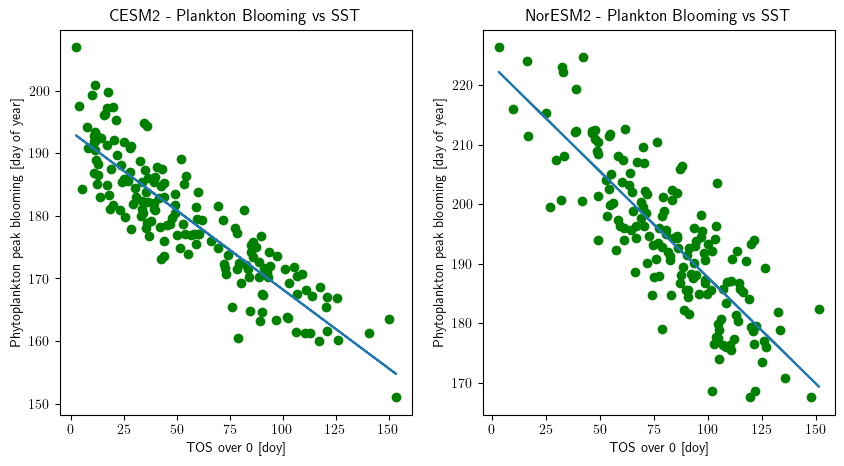

In [333]:
fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
ax[0].set_xlabel('TOS over 0 [doy]')
ax[0].set_ylabel('Phytoplankton peak blooming [day of year]')
ax[0].set_title('CESM2 - Plankton Blooming vs SST')
ax[0].scatter(TOSCesmHistDatesMean.values, chlosCesmHistPeaksMean.values, color='g')
ax[0].plot(TOSCesmHistDatesMean.values, regCesm.params[1] * TOSCesmHistDatesMean.values + regCesm.params[0])
ax[1].set_xlabel('TOS over 0 [doy]')
ax[1].set_ylabel('Phytoplankton peak blooming [day of year]')
ax[1].set_title('NorESM2 - Plankton Blooming vs SST')
ax[1].scatter(TOSNoresmHistDatesMean.values, chlosNoresmHistPeaksMean.values, color='g')
ax[1].plot(TOSNoresmHistDatesMean.values, regNoresm.params[1] * TOSNoresmHistDatesMean.values + regNoresm.params[0])

### Variables that could explain plankton bloom
- Sea ice break up (50%)
- Sea ice break up (15%)
- Temperature in june
- Temperature in other months
- Mixed layer depth in june or other months

In [446]:
oml = regional_average(MLCesmHist, model='CESM2')

Found local areacello NetCDF


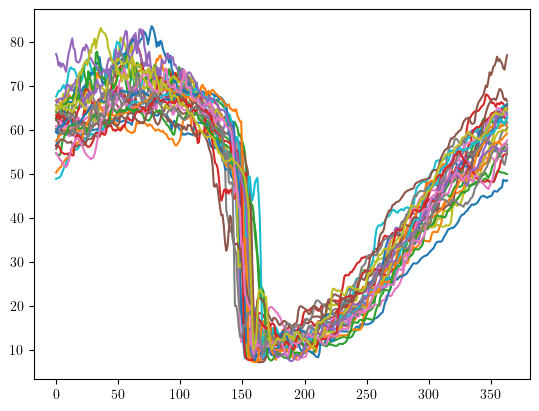

In [449]:
for i in range(1, 30):
    plt.plot(np.arange(364), oml.isel(time=slice((i+1)*(-365), -365*i - 1)).values)

In [461]:
dfCesm = pd.DataFrame([chlosCesmHistPeaksMean.values,
                       SICesmHistDates90Mean.values,
                       SICesmHistDates80Mean.values,
                       SICesmHistDatesMean.values,
                       SICesmHistDates15Mean.values,
                       monthly_mean(TOSCesmHist, 5, 'CESM2').values, 
                       monthly_mean(TOSCesmHist, 6, 'CESM2').values, 
                       monthly_mean(TOSCesmHist, 7, 'CESM2').values, 
                       monthly_mean(TOSCesmHist, 8, 'CESM2').values, 
                       monthly_mean(MLCesmHist, 4, 'CESM2').values, 
                       monthly_mean(MLCesmHist, 5, 'CESM2').values, 
                       monthly_mean(MLCesmHist, 6, 'CESM2').values]).T
dfNoresm = pd.DataFrame([chlosNoresmHistPeaksMean.values,
                         SINoresmHistDates90Mean.values,
                         SINoresmHistDates80Mean.values,
                         SINoresmHistDatesMean.values,
                         SINoresmHistDates15Mean.values,
                         monthly_mean(TOSNoresmHist, 5, 'NorESM2-LM').values, 
                         monthly_mean(TOSNoresmHist, 6, 'NorESM2-LM').values, 
                         monthly_mean(TOSNoresmHist, 7, 'NorESM2-LM').values,
                         monthly_mean(TOSNoresmHist, 8, 'NorESM2-LM').values,
                         monthly_mean(MLCesmHist, 4, 'NorESM2-LM').values, 
                         monthly_mean(MLCesmHist, 5, 'NorESM2-LM').values, 
                         monthly_mean(MLCesmHist, 6, 'NorESM2-LM').values]).T
dfCesm.columns = dfNoresm.columns = ['PBD', 'SIBD90', 'SIBD80', 'SIBD50', 'SIBD15', 
                                     'Mean May SST', 'Mean June SST', 'Mean July SST', 'Mean August SST', 
                                     'Mean April MLD', 'Mean May MLD', 'Mean June MLD']
#dfNoresm.columns = ['PBD', 'SIBD', 'Mean May SST', 'Mean June SST', 'Mean July SST', 'Mean August SST']

In [462]:
dfCesm.corr()

,PBD,SIBD90,SIBD80,SIBD50,SIBD15,Mean May SST,Mean June SST,Mean July SST,Mean August SST,Mean March MLD,Mean May MLD,Mean June MLD
PBD,1.000000,0.833191,0.867263,0.628556,-0.147565,-0.739108,-0.854205,-0.907637,-0.871671,0.256792,0.653939,0.422335
SIBD90,0.833191,1.000000,0.859363,0.555372,-0.194297,-0.680216,-0.743764,-0.774892,-0.751928,0.179332,0.579159,0.378613
SIBD80,0.867263,0.859363,1.000000,0.753114,-0.067698,-0.723423,-0.803524,-0.850134,-0.823899,0.154689,0.603422,0.319900
SIBD50,0.628556,0.555372,0.753114,1.000000,0.468927,-0.639977,-0.684584,-0.705072,-0.627137,0.121253,0.506964,0.258285
SIBD15,-0.147565,-0.194297,-0.067698,0.468927,1.000000,-0.111094,-0.061028,0.021943,0.140719,-0.031191,0.058341,-0.007425
Mean May SST,-0.739108,-0.680216,-0.723423,-0.639977,-0.111094,1.000000,0.882695,0.784980,0.711688,-0.256758,-0.712606,-0.252056
Mean June SST,-0.854205,-0.743764,-0.803524,-0.684584,-0.061028,0.882695,1.000000,0.910333,0.827835,-0.217374,-0.674784,-0.367902
Mean July SST,-0.907637,-0.774892,-0.850134,-0.705072,0.021943,0.784980,0.910333,1.000000,0.959950,-0.260617,-0.698614,-0.374486
Mean August SST,-0.871671,-0.751928,-0.823899,-0.627137,0.140719,0.711688,0.827835,0.959950,1.000000,-0.251210,-0.658774,-0.329392
Mean March MLD,0.256792,0.179332,0.154689,0.121253,-0.031191,-0.256758,-0.217374,-0.260617,-0.251210,1.000000,0.548113,0.038021


In [468]:
dfNoresm.corr()

,PBD,SIBD90,SIBD80,SIBD50,SIBD15,Mean May SST,Mean June SST,Mean July SST,Mean August SST,Mean March MLD,Mean May MLD,Mean June MLD
PBD,1.000000,0.883108,0.908366,0.765882,0.113604,-0.804061,-0.882005,-0.897846,-0.871111,-0.134447,0.034956,0.182461
SIBD90,0.883108,1.000000,0.957396,0.802534,0.169918,-0.830317,-0.860501,-0.823367,-0.798093,-0.130820,0.073890,0.194095
SIBD80,0.908366,0.957396,1.000000,0.868749,0.216518,-0.865222,-0.897548,-0.883369,-0.856200,-0.115974,0.077671,0.205752
SIBD50,0.765882,0.802534,0.868749,1.000000,0.574046,-0.848960,-0.843648,-0.807922,-0.740842,-0.055872,0.125902,0.224972
SIBD15,0.113604,0.169918,0.216518,0.574046,1.000000,-0.413564,-0.323965,-0.223197,-0.085912,0.025288,0.120492,0.102716
Mean May SST,-0.804061,-0.830317,-0.865222,-0.848960,-0.413564,1.000000,0.940129,0.852680,0.790459,0.122184,-0.045410,-0.207663
Mean June SST,-0.882005,-0.860501,-0.897548,-0.843648,-0.323965,0.940129,1.000000,0.933126,0.868423,0.136560,-0.068591,-0.227956
Mean July SST,-0.897846,-0.823367,-0.883369,-0.807922,-0.223197,0.852680,0.933126,1.000000,0.950248,0.098817,-0.096008,-0.222049
Mean August SST,-0.871111,-0.798093,-0.856200,-0.740842,-0.085912,0.790459,0.868423,0.950248,1.000000,0.055104,-0.089250,-0.195553
Mean March MLD,-0.134447,-0.130820,-0.115974,-0.055872,0.025288,0.122184,0.136560,0.098817,0.055104,1.000000,0.686960,0.022023


### All years visualized

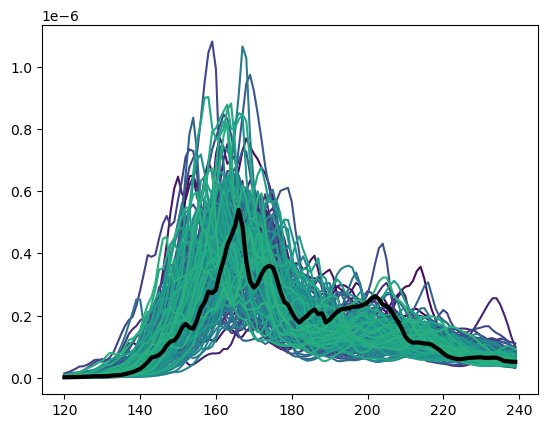

In [89]:
fig, ax = plt.subplots()
#average_yearly_cycle = chlos_daily_mean.chlos.groupby('time.dayofyear').mean()

cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist = cmaplist[::int(cmap.N/165)]
#cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.arange(1850, 2015)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

chlos_daily_mean_grouped = chlos_daily_mean.chlos.groupby('time.year')
[ax.plot(np.arange(120, 120+30*4), chlos_daily_mean_grouped[year].isel(time=slice(120, 120+30*4)), color=cmaplist[year-1850]) for year in range(1850, 2014)]

ax.plot(np.arange(120, 120+30*4), chlos_daily_mean.chlos.isel(time=slice(120, 120+30*4)), linewidth=3, color='k')
#ax.legend()
plt.show()

Do we see a shift in the peak phytoplankton blooming date in the Barentz sea in connection to the sea ice retreat?

In [11]:
start = time.time()
with ProgressBar():
    chlos_daily_mean.compute()
print(time.time() - start)

0.027305126190185547


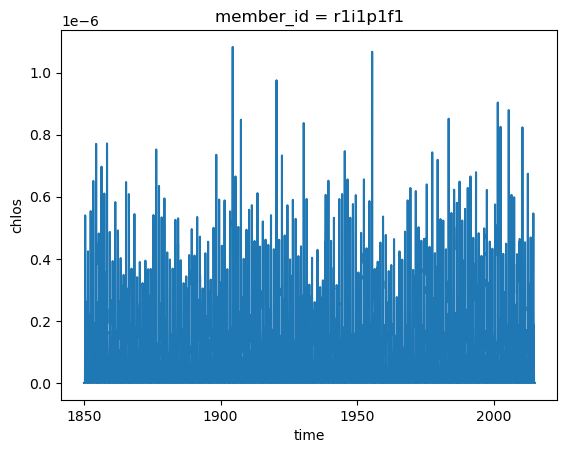

In [18]:
chlos_daily_mean.chlos.plot()

### Notes

"Because cold waters tend to have more nutrients than warm waters, phytoplankton tend to be more plentiful where waters ware cold.
"

månedlig noresm chlos for å se peak, plotte oppå /OBS-ESACCI-OC/

For NorESM2 chlorophyll, time by 10 to get total mass when integrating for surface layer

- Get daily observations

- Repeat for CESM

- Repeat for NorESM-SSP385